This notebook analyzed the Amazon product reviews for bluebooth headphones, and the intention is to find the suspecious patterns on the products review, together with the grade found on FakeSpot by Mozilla.

There are two main parts on this notebook, the first part on extracting review data from Amazon by Selenium. The second part focus on the analysis on the patterns of the reviews.

# Data Extraction by Selenium

In [2]:
from Fakespot.amazon_scraper import AmazonReviewScraper
from selenium.webdriver.common.by import By
import os, json
os.environ["AMAZON_CREDENTIAL"] = "/Users/jinli1/Projects/jing-toy/.vscode/amazon_credential.json"
amazon_credential_path = os.environ["AMAZON_CREDENTIAL"]
with open(amazon_credential_path, "r") as file:
    amazon_credential = json.load(file)

ars = AmazonReviewScraper(amazon_credential["username"], amazon_credential["password"], "Fakespot/download", "Fakespot/download")
ars.sign_in()

{'browserName': 'chrome', 'pageLoadStrategy': <PageLoadStrategy.normal: 'normal'>, 'goog:chromeOptions': {'prefs': {'credentials_enable_service': False, 'profile.password_manager_enabled': False, 'autofill.profile_enabled': False, 'credentials_offer_save_update_password': False, 'password_manager_offer_save_update_password': False, 'password_manager_enable_autosignin': False, 'goog:localPasskeySetting': False}, 'extensions': [], 'args': ['--password-store=basic', '--incognito']}}


True

### Extract the text message on each product review pages on count of ratings and reviews

In [ ]:
page_to_extract = 10
review_rating_dict = ars.find_similar_product_review_rating_counts(page_to_extract)

In [3]:
product_review_count = {}
for url, count_str in review_rating_dict.items():
    product_review_count.setdefault(url, {})
    product_review_count[url]["total_ratings"]=AmazonReviewScraper.extract_ratings_and_reviews(count_str)[0]
    product_review_count[url]["total_reviews"]=AmazonReviewScraper.extract_ratings_and_reviews(count_str)[1]
    product_review_count[url]["review_rating_ratio"] = product_review_count[url]["total_reviews"]/product_review_count[url]["total_ratings"]

<Axes: ylabel='Count'>

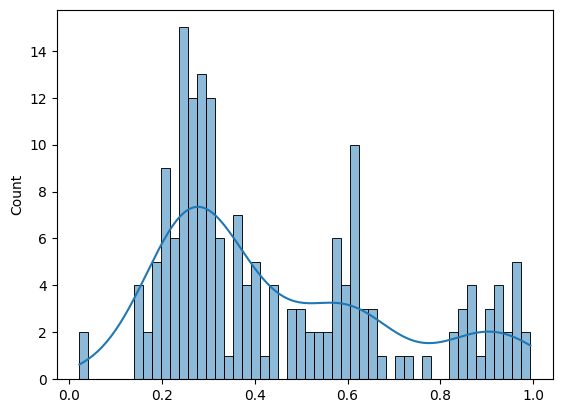

In [5]:
import seaborn as sns
ratios = [p_dict["review_rating_ratio"] for p_dict in product_review_count.values() if p_dict["review_rating_ratio"] < 1]
sns.histplot(ratios, bins=50, kde=True)

In [ ]:
# import pickle
# with open("review_rating_dict.pkl", 'wb') as f:  # 'wb' for writing in binary mode
#     pickle.dump(product_review_count, f)
#     print(f"Dictionary successfully saved.")

Dictionary successfully saved.


In [ ]:
# import pickle
# with open("review_rating_dict.pkl", 'rb') as f:  # 'wb' for writing in binary mode
#     review_rating_dict = pickle.load(f)
#     print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


### Extract the Fakespot grade for those products

In [ ]:
fakesport_grade = dict()
for product_url in review_rating_dict.keys():
    try:
        fakespot_grade = ars.get_fakespot_grade(product_url)
        fakesport_grade[product_url] = fakespot_grade
        print(fakespot_grade, product_url)
    except:
        continue

In [54]:
grade_product_dict = {}
for url, grade in fakesport_grade.items():
    grade_product_dict.setdefault(grade, [])
    grade_product_dict[grade].append(url)


In [ ]:
# import pickle
# with open("fakesport_grade.pkl", 'wb') as f:  # 'wb' for writing in binary mode
#     pickle.dump(fakesport_grade, f)
#     print(f"Dictionary fakesport_grade successfully saved.")

Dictionary fakesport_grade successfully saved.


In [60]:
# Get product review for all

### Get the product review for all above product

Note: there's a limitation on the number of review we can see from the product review page. So to standarize the review data, we always get the reviews "by recent" and extract all reviews on the page, every product has maximum of 100 reviews (could be less if the acutal number of reviews are less than it)

In [300]:
len(product_reviews["https://www.amazon.com/All-new-Echo-Buds-2023-Release-True-Wireless-Earbuds/dp/B09JVG3TWX/ref=sr_1_1_ffob_sspa?crid=M1DX8W8XBEQT&dib=eyJ2IjoiMSJ9.bTFkD9YnfceG1rew4BweQEgvpYDwaXOJKkvJIAFPZ2WgyhL9uq2IIv_83UDA4vYHyQIK76uxWFqT490fOAd41iVYIh5pKFWjNrsEJb0UiYHNiKdIFQxhEN3iAtvlUXaI94MGrbj0Fw0uRhuLA26kcgQ50hkvzQg1iTtzYH-hSLF1Ify3ao0Ww5Ul2gHTBvQolNENbgTAwxf68CvmlZfR29v1l2OedOkV9r6U-3sVl58.Z_--Eky-eJEDCToWNiI2THaKZx3A99yM-Lz0Ot08ZBo&dib_tag=se&keywords=bluetooth+headphones&qid=1736130100&sprefix=bluetooth+headphones%2Caps%2C124&sr=8-1-spons&sp_csd=d2lkZ2V0TmFtZT1zcF9hdGY&psc=1"])

100

In [ ]:
product_reviews = {}
for url, grade in fakesport_grade.items():
    ars.driver.get(url)
    ars.driver.find_element(By.ID, "acrCustomerReviewText").click()
    ars.driver.find_element(By.CSS_SELECTOR, "a[data-hook='see-all-reviews-link-foot']").click()
    review_dict = ars.find_all_reviews(ars.driver.current_url, 20)
    product_reviews[url] = review_dict


In [ ]:
# import pickle
# with open("product_reviews.pkl", 'wb') as f:  # 'wb' for writing in binary mode
#     pickle.dump(product_reviews, f)
#     print(f"Dictionary product_reviews successfully saved.")

Dictionary product_reviews successfully saved.


# Generate standard features for reviews

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

def preprocess_text_and_get_tokens(text):
    """Preprocesses a given text string."""

    # 1. Lowercasing
    text = text.lower()
    # 2. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 4. Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
     # 6. Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 7. Tokenization
    tokens = word_tokenize(text)
    # 8. Remove Stop Words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # 9. Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def extract_features(tokens):
    """Extract features from tokenized text."""

    text = " ".join(tokens)
    feature_dict = {}

    # Basic Features
    feature_dict["word_count"] = len(tokens)
    feature_dict["avg_word_len"] = sum(len(word) for word in tokens) / len(tokens) if tokens else 0
    feature_dict["unique_word_count"] = len(set(tokens))

    # Sentiment Features
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    feature_dict["sentiment_pos"] = scores["pos"]
    feature_dict["sentiment_neg"] = scores["neg"]
    feature_dict["sentiment_neu"] = scores["neu"]
    feature_dict["sentiment_comp"] = scores["compound"]

    return feature_dict

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def calculate_tfidf(reviews):
    """Calculate TF-IDF features for all reviews"""

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(reviews)
    feature_names = vectorizer.get_feature_names_out()

    # Convert the sparse matrix into a list of dictionaries
    tfidf_scores = []
    for i in range(tfidf_matrix.shape[0]):
       row_data = {}
       row_values = tfidf_matrix.getrow(i).toarray().flatten() # Convert to dense array
       for j in range(len(feature_names)):
           row_data[f"tfidf_{feature_names[j]}"] = row_values[j]
       tfidf_scores.append(row_data)

    return tfidf_scores

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#function to split text into word
for r_dict in (review_dict, review_dict_a):
    for review_id, review_d in r_dict.items():
        # create tokens
        tokens = preprocess_text_and_get_tokens(review_d["review_text"])
        review_d["tokens"] = tokens

        # extract basic features
        feature_dict = extract_features(review_d["tokens"])
        review_d["feature_dict"] = feature_dict

        # reconstruct string by token 
        token_string = " ".join([token for token in review_d["tokens"]])
        review_d["token_string"] = token_string

        # create feature list
        feature_list = []
        feature_list.append(review_d["has_image"])
        feature_list.append(review_d["has_video"])
        feature_list.append(review_d["review_rating"])
        feature_list.extend(list(review_d["feature_dict"].values()))
        review_d["features"] = feature_list

In [301]:
# import pandas as pd

# df_product_f = pd.DataFrame([d["features"] for d in review_dict.values()], index=[id for id in review_dict.keys()], columns=[f"feature_{n}" for n in range(10)])
# df_product_a = pd.DataFrame([d["features"] for d in review_dict_a.values()], index=[id for id in review_dict_a.keys()], columns=[f"feature_{n}" for n in range(10)])

# df_product_f["token_string"] = [d["token_string"] for d in review_dict.values()]
# df_product_f["suspecious"] = 1
# df_product_a["token_string"] = [d["token_string"] for d in review_dict_a.values()]
# df_product_a["suspecious"] = 0

# df_product_a["count_ratio"] = 0.22
# df_product_f["count_ratio"] = 0.96

# df_product_review = pd.concat([df_product_a, df_product_f])

In [302]:
# from sklearn.model_selection import train_test_split, GridSearchCV

# # Split data
# X = df_product_review['token_string']
# y = df_product_review['suspecious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.feature_extraction import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)

# # extract only features from df and join with TF-IDF features
# X_train_df = df_product_review.loc[X_train.index, [col for col in df_product_review.columns if col.startswith("feature") or col == "count_ratio"]]
# X_train_df = X_train_df.join(pd.DataFrame(X_train_vec.toarray()))
# X_test_df = df_product_review.loc[X_test.index, [col for col in df_product_review.columns if col.startswith("feature") or col == "count_ratio"]]
# X_test_df = X_test_df.join(pd.DataFrame(X_test_vec.toarray()))

# X_train, X_test = X_train_df.values, X_test_df.values
# from sklearn.preprocessing import MinMaxScaler
  
# scaler = MinMaxScaler()
# X_train_features_scaled = scaler.fit_transform(X_train)
# X_test_features_scaled = scaler.transform(X_test)

In [ ]:
# # model

# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Address class imbalance

# # Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
#     }
# # Parameter tuning
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_features_scaled, y_train)

# # Get best model and its best parameters
# model = grid_search.best_estimator_
# print("Best parameters:", grid_search.best_params_)
# from sklearn.metrics import accuracy_score, classification_report

# y_pred = model.predict(X_test_features_scaled)
# print("\nEvaluation Metrics:")
# print(classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

def classify_reviews(reviews_df, model_type='logistic_regression'):
  """
    Classifies reviews as reliable or fake.

    Args:
        reviews_df: Pandas DataFrame with 'text' column and 'label' column
        model_type: str: 'logistic_regression', or 'random_forest'

    Returns:
        Trained model and evaluation metrics
  """

  # 1. Split data
  X = reviews_df['text']
  y = reviews_df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # 2. TF-IDF vectorization
  vectorizer = TfidfVectorizer()
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  # Scale the TF-IDF matrix
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train_vec.toarray())
  X_test_scaled = scaler.transform(X_test_vec.toarray())

  # 3. Model Training
  if model_type == 'logistic_regression':
    model = LogisticRegression(random_state=42, class_weight='balanced') # Address class imbalance

    # Define parameter grid
    param_grid = {
      'C': [0.01,0.1, 1, 10],
      'penalty': ['l1', 'l2'],
      'solver': ['liblinear']
     }
    # Parameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_scaled, y_train)

    # Get best model and its best parameters
    model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)

  elif model_type == 'random_forest':
    model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Address class imbalance

    # Define parameter grid
    param_grid = {
       'n_estimators': [50, 100, 200],
       'max_depth': [5, 10, 15],
       'min_samples_split': [2, 5, 10],
       'min_samples_leaf': [1, 2, 4]
     }
    # Parameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_scaled, y_train)

    # Get best model and its best parameters
    model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
  else:
    raise ValueError("Model type not supported")

  # 4. Evaluate Model
  y_pred = model.predict(X_test_scaled)
  print("\nEvaluation Metrics:")
  print(classification_report(y_test, y_pred))
  print("Accuracy:", accuracy_score(y_test, y_pred))
  return model, classification_report(y_test, y_pred), accuracy_score(y_test, y_pred)

if __name__ == '__main__':
    # Example Usage
    data = {
        'text': [
            "This product is absolutely amazing! I'm so happy with my purchase!",
            "The item arrived broken. Do not buy this.",
            "It's an okay product, nothing special.",
            "I am so incredibly disappointed. Worst purchase ever!",
            "Great product, fast shipping.",
            "Fantastic deal! Exceeded my expectations.",
            "Complete junk. Doesn't work as advertised.",
            "This product is pure gold, amazing quality!",
            "A waste of money. Save your cash.",
            "This has been a lifesaver! Highly recommend it!",
            "The product sucks! Don't buy!",
            "I have never had so much satisfaction before buying this",
            "Complete garbage! Do not buy!",
            "This product is really good",
            "This is an average product",
            "Great product!",
            "I had a great experience with this product",
             "This product was so good i had to buy more",
        ],
        'label': [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,1]
    }
    reviews_df = pd.DataFrame(data)
    # You should be creating labels based on which product the reviews came from
    trained_model, class_report, accuracy = classify_reviews(reviews_df, 'logistic_regression')
    trained_model_random_forest, class_report_rf, accuracy_rf = classify_reviews(reviews_df, 'random_forest')
    print("trained_model_random_forest", trained_model_random_forest)
    print("classification_report for Random forest", class_report_rf)
    print("Accuracy for Random forest", accuracy_rf)

/Users/jinli1/Projects/jing-toy/jing-toy/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jinli1/Projects/jing-toy/jing-toy/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Evaluation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

Accuracy: 0.75
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

Accuracy: 0.75
trained_model_random_forest RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_le

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#function to split text into word
product_features = {}
for product_url, p_dict in product_reviews.items():
    product_features.setdefault(product_url, {})
    for review_id, review_d in p_dict.items():
        # create tokens
        product_features[product_url].setdefault(review_id, {})
        tokens = preprocess_text_and_get_tokens(review_d["review_text"])
        product_features[product_url][review_id]["tokens"] = tokens

        # extract basic features
        feature_dict = extract_features(product_features[product_url][review_id]["tokens"])
        product_features[product_url][review_id]["feature_dict"] = feature_dict

        # reconstruct string by token 
        token_string = " ".join([token for token in product_features[product_url][review_id]["tokens"]])
        product_features[product_url][review_id]["token_string"] = token_string

        # create feature list
        feature_list = []
        feature_list.append(review_d["has_image"])
        feature_list.append(review_d["has_video"])
        feature_list.append(review_d["review_rating"])
        feature_list.extend(list(product_features[product_url][review_id]["feature_dict"].values()))
        product_features[product_url][review_id]["features"] = feature_list

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_35480/1869277840.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [110]:
import pandas as pd
dfs = []
for product_url, reviews in product_features.items():
    df_product_features = pd.DataFrame({review_id: (d["features"] + [d["token_string"]]) for review_id, d in product_features[product_url].items()}).T
    df_product_features.columns = [f"feature_{n}" for n in range(10)] + ["token_string"]
    df_product_features["product_url"] = product_url
    df_product_features["review_rating_ratio"] = review_rating_dict[product_url]["review_rating_ratio"]
    df_product_features["product_fakespot_grade"] = fakesport_grade[product_url]
    dfs.append(df_product_features)

In [112]:
df_all_product_features = pd.concat(dfs)

In [ ]:
# import pickle
# with open("df_all_product_features.pkl", 'wb') as f:  # 'wb' for writing in binary mode
#     pickle.dump(df_all_product_features, f)
#     print(f"Dictionary df_all_product_features successfully saved.")

Dictionary df_all_product_features successfully saved.


In [1]:
import pickle
with open("df_all_product_features.pkl", 'rb') as f:  # 'wb' for writing in binary mode
    df_all_product_features = pickle.load(f)
    print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


In [385]:
df_all_product_features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,token_string,product_url,review_rating_ratio,product_fakespot_grade
R30SZV56T07JOV,False,False,4,9,6.111111,7,0.577,0.0,0.423,0.8012,quality sound really good good quality materia...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R2YD8IZAN1L5QV,False,False,1,20,4.5,17,0.0,0.217,0.783,-0.6124,difficult pair pair alexa never got work even ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1SG3KLESASNYO,False,False,4,4,5.5,4,0.516,0.0,0.484,0.4927,price product really good,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1BRUHA6158TD1,False,False,1,14,5.357143,14,0.326,0.163,0.512,0.5423,product performs 20 ear bud design great idea ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R3IK00EI1WUVQO,False,False,4,7,5.714286,7,0.406,0.0,0.594,0.6249,great battery life connection volume 100 phone,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R3FRDB5B4OBRUA,False,False,2,48,5.25,42,0.128,0.053,0.819,0.4703,despite use 54 bluetooth chip 142 mm driver so...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R1K92OG4FIP8XR,False,False,5,40,5.975,35,0.507,0.0,0.493,0.9832,absolutely fantastic use driving job great bat...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R3898SHCPYITBL,False,False,5,44,4.568182,41,0.445,0.063,0.493,0.9766,work awesome airpod pro 2 new one spent 270 le...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R23NZFM6ADIX2Q,False,False,5,26,4.423077,21,0.503,0.0,0.497,0.9649,love color fit comfortable ear case let know m...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F


In [113]:
df_all_product_features["token_string"].values

array(['quality sound really good good quality material recommended 100',
       'difficult pair pair alexa never got work even difficult return eat cost must box get ups label find ups store',
       'price product really good', ...,
       'work awesome airpod pro 2 new one spent 270 let tell super crisp lol even joking hated everybody would tell sound muffled airpods man saw sale bought every body telling phone call sound super clear perfect buy oh music loud great bass nice jump',
       'love color fit comfortable ear case let know much charge one case use one time last long time one charge sound really good great value price',
       'los probado durante 3 dia estan muy buenos tienen buena calidad del sonido son comodos'],
      shape=(18495,), dtype=object)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer # notice the spelling with the f before Vectorizer

vectorizer = TfidfVectorizer()
X_tfidf_vec = vectorizer.fit_transform(df_all_product_features["token_string"].values)

In [10]:
type(X_tfidf_vec)

scipy.sparse._csr.csr_matrix

In [11]:
import pandas as pd
df_all_with_tfidf = df_all_product_features.join(pd.DataFrame(X_tfidf_vec.toarray()))

In [23]:
df_all_with_tfidf_fillna = df_all_with_tfidf.fillna(0)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_93323/78059533.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_with_tfidf_fillna = df_all_with_tfidf.fillna(0)


In [15]:
feature_cols = [col for col in df_all_with_tfidf.columns if col not in ["token_string", "product_url", "product_fakespot_grade"]]

In [133]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
import hdbscan



def cluster_text(features, n_clusters=6, reduction_method="pca", model="kmeans", use_cosine=True, do_scale=True):
    if reduction_method == "pca":
       pca = PCA(n_components=min(50, features.shape[1]))
       reduced_features = pca.fit_transform(features)

        # Assuming feature_matrix is your 1000+ dimensional feature matrix

        # --- Truncated SVD ---
    elif reduction_method == "truncatedSVD":
        svd = TruncatedSVD(n_components=100)  # Reduce to, say, 100 dimensions
        reduced_features = svd.fit_transform(features)

    else:
        reduced_features = features


    if do_scale:
        scaler = StandardScaler()
        reduced_features = scaler.fit_transform(reduced_features)
    if model=="kmeans":
        if use_cosine:
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        else:
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)

        kmeans.fit(reduced_features)
        labels = kmeans.labels_
    elif model=="hdbscan":

        # HDBSCAN
        hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=n_clusters)
        labels = hdbscan_cluster.fit_predict(features)

    return labels

In [78]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)  # Reduce to 2D
tsne_result = tsne.fit_transform(df_all_with_tfidf_fillna[feature_cols].values)

In [85]:
df_v = pd.DataFrame(tsne_result)

In [ ]:
df_all_with_tfidf_filled = df_all_with_tfidf[feature_cols].fillna(0)
df_all_with_tfidf_filled = df_all_with_tfidf_filled.replace(False, 0)
df_all_with_tfidf_filled = df_all_with_tfidf_filled.replace(True, 1)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_93323/3208252584.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_with_tfidf_filled = df_all_with_tfidf[feature_cols].fillna(0)


/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_93323/4003992358.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_with_tfidf_filled = df_all_with_tfidf_filled.replace(True, 1)


In [183]:
df_all_with_tfidf["product_fakespot_grade"].value_counts()

product_fakespot_grade
B    9458
A    4514
C    2041
D    1300
F    1161
?      21
Name: count, dtype: int64

In [184]:
grades = df_all_with_tfidf["product_fakespot_grade"].unique()
df_filtered_with_tfidf = [df_all_with_tfidf[df_all_with_tfidf["product_fakespot_grade"]==grade][:1000] for grade in grades]

In [187]:
df_filtered_with_tfidf = pd.concat(df_filtered_with_tfidf)

In [192]:
df_filtered_with_tfidf_filled = df_filtered_with_tfidf[feature_cols].fillna(0)
df_filtered_with_tfidf_filled = df_filtered_with_tfidf_filled.replace(False, 0)
df_filtered_with_tfidf_filled = df_filtered_with_tfidf_filled.replace(True, 1)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_93323/2230128337.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered_with_tfidf_filled = df_filtered_with_tfidf[feature_cols].fillna(0)
/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_93323/2230128337.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered_with_tfidf_filled = df_filtered_with_tfidf_filled.replace(True, 1)


In [194]:
features = df_filtered_with_tfidf_filled[feature_cols].values

In [195]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [160]:
svd = TruncatedSVD(n_components=50)  # Reduce to, say, 100 dimensions
reduced_features = svd.fit_transform(scaled_features)

In [ ]:
# scaler = StandardScaler()
# reduced_features = scaler.fit_transform(reduced_features)

In [196]:
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=6)
labels = hdbscan_cluster.fit_predict(reduced_features)

/Users/jinli1/Projects/jing-toy/jing-toy/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jinli1/Projects/jing-toy/jing-toy/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [146]:
# labels = cluster_text(df_all_with_tfidf_fillna[feature_cols].values, reduction_method="truncatedSVD", model="hdbscan")

In [ ]:
# scaler = StandardScaler()
# reduced_features = scaler.fit_transform(df_all_with_tfidf_fillna[feature_cols].values)

In [162]:
svd_v = TruncatedSVD(n_components=2)  # Reduce to, say, 100 dimensions
reduced_features_visual = svd.fit_transform(scaled_features)
# pca_visual = PCA(n_components=2)
# reduced_features_visual = pca_visual.fit_transform(reduced_features)

In [ ]:
# scaler = StandardScaler()
# reduced_features_visual_r = scaler.fit_transform(reduced_features_visual)

In [163]:
df_v = pd.DataFrame(reduced_features_visual)

In [164]:
df_v["label"] = df_all_with_tfidf["product_fakespot_grade"].values
df_v["k_means_label"] = labels

In [168]:
df_v["k_means_label"].unique()

array([ -1, 175,   3, 383, 433, 131, 145,  68,  90,  45,  22,  17, 170,
         6,  41, 183, 209, 201, 220, 406, 198, 190, 470, 238,  14, 449,
       315,  35,  93,  36, 120, 229, 299, 182, 404, 438, 262,  11, 213,
       210, 446, 370, 359, 354, 329, 134, 199, 172, 330, 279, 205, 364,
        49, 346, 422, 291, 353, 345, 310,  83, 453, 374, 332, 295,   0,
       411, 318,  94, 302, 306, 316, 474, 391, 278, 451, 119, 349,  95,
       109, 320, 166,  71, 214, 125, 105, 264, 421, 336, 208, 181, 155,
       480, 458, 301, 188, 351, 106, 221, 426, 419, 234, 161,  16, 442,
       309, 467, 331, 472,  30, 484,  88,  18, 297, 272,  96, 416, 154,
       447, 251, 308, 314, 357, 282, 468, 365, 138, 261, 228, 266, 141,
       479,   9, 466, 355, 153, 375, 379, 129, 488,   1, 217,  70, 180,
       403, 443, 224,  99, 192, 341, 150, 173,  53,  87, 250,  27, 380,
         2, 481, 420, 178, 184, 469,  85, 148, 263, 418, 385, 146,  52,
         8,   5, 321, 473, 237, 483,  19, 487, 245, 413, 425, 47

In [197]:
# import matplotlib.pyplot as plt
# # Get unique labels for color mapping
# x = df_v[0]
# y = df_v[1]
# labels = df_v['k_means_label']

# # Get unique labels for color mapping
# unique_labels = np.unique(labels)

# # Create a colormap
# cmap = plt.cm.get_cmap('viridis', len(unique_labels)) # you can use other colormaps

# # Create the scatter plot
# plt.figure(figsize=(8, 6))  # Adjust figure size if needed
# for i, label in enumerate(unique_labels):
#     # Get data points for each label
#     x_cluster = x[labels == label]
#     y_cluster = y[labels == label]

#     # Plot using the color from colormap
#     plt.scatter(x_cluster, y_cluster, label=label, color = cmap(i))
  
# # Add labels and title
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.title("Scatter Plot with Cluster Labels")
# plt.legend()  # Show the legend
# plt.grid(True)
# plt.show()

<Axes: xlabel='0', ylabel='1'>

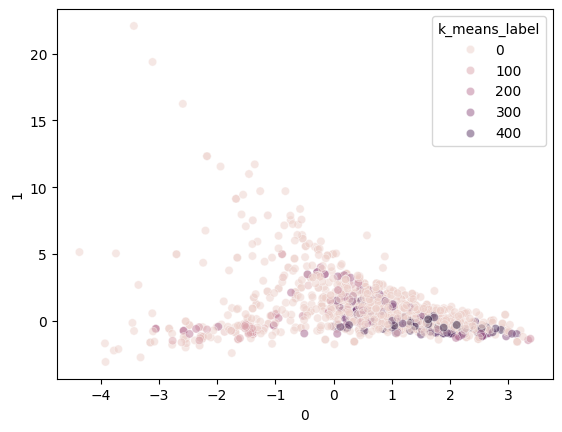

In [175]:
import seaborn as sns
sns.scatterplot(x=df_v[df_v["label"]=="F"][0], y=df_v[df_v["label"]=="F"][1], hue=df_v[df_v["label"]=="F"]["k_means_label"],alpha=0.5)


<Axes: xlabel='0', ylabel='1'>

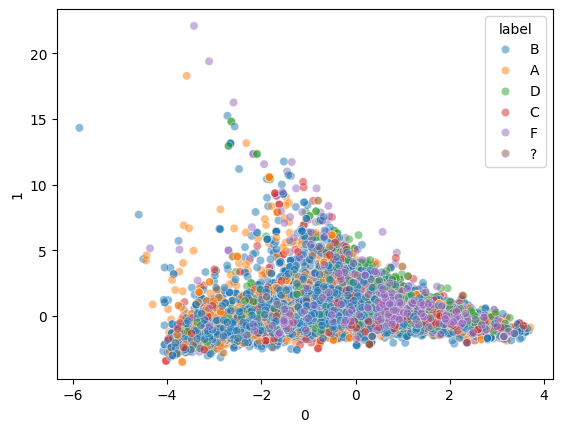

In [177]:
sns.scatterplot(x=df_v[df_v["k_means_label"]<150][0], y=df_v[df_v["k_means_label"]<150][1], hue=df_v[df_v["k_means_label"]<150]["label"],alpha=0.5)


In [180]:
df_v[df_v["k_means_label"]<150]["label"].value_counts()

label
B    7238
A    3223
C    1610
D    1072
F     940
?      19
Name: count, dtype: int64

In [181]:
df_v[df_v["k_means_label"]>150]["label"].value_counts()

label
B    2207
A    1289
C     427
D     228
F     221
?       2
Name: count, dtype: int64

In [125]:
df_v[df_v["label"]=="B"]["k_means_label"].value_counts()

k_means_label
2    4036
0    3463
1    1514
4     246
3     100
5      99
Name: count, dtype: int64

In [126]:
df_v[df_v["label"]=="A"]["k_means_label"].value_counts()

k_means_label
2    1974
0    1597
1     714
4     130
3      99
Name: count, dtype: int64

In [127]:
df_v[df_v["label"]=="C"]["k_means_label"].value_counts()

k_means_label
2    889
0    705
1    310
5     99
4     38
Name: count, dtype: int64

In [128]:
df_v[df_v["label"]=="D"]["k_means_label"].value_counts()

k_means_label
0    559
2    369
1    292
4     80
Name: count, dtype: int64

In [129]:
df_v[df_v["label"]=="F"]["k_means_label"].value_counts()

k_means_label
0    417
2    350
1    305
4     89
Name: count, dtype: int64

In [130]:
df_v[df_v["label"]=="?"]["k_means_label"].value_counts()

k_means_label
0    15
1     3
2     3
Name: count, dtype: int64

<Axes: xlabel='0', ylabel='1'>

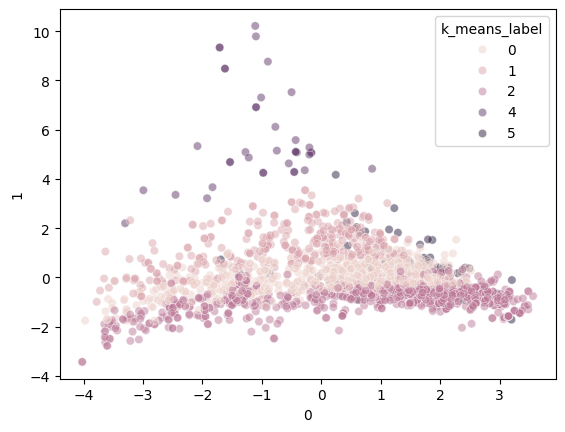

In [117]:
sns.scatterplot(x=df_v[df_v["label"]=="C"][0], y=df_v[df_v["label"]=="C"][1], hue=df_v[df_v["label"]=="C"]["k_means_label"],alpha=0.5)


<Axes: xlabel='0', ylabel='1'>

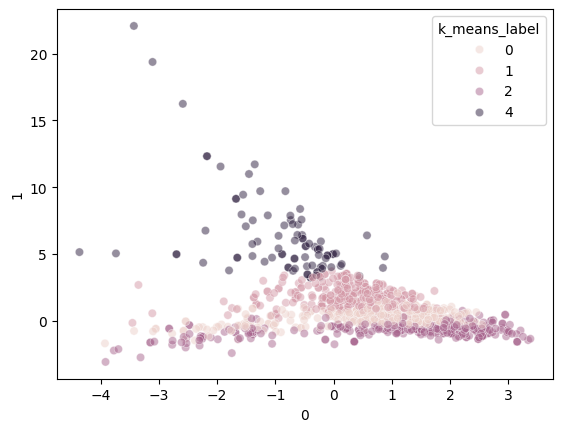

In [119]:
sns.scatterplot(x=df_v[df_v["label"]=="F"][0], y=df_v[df_v["label"]=="F"][1], hue=df_v[df_v["label"]=="F"]["k_means_label"],alpha=0.5)


<Axes: xlabel='0', ylabel='1'>

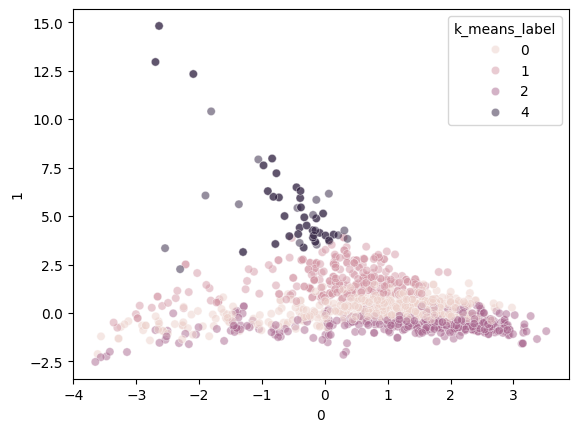

In [120]:
sns.scatterplot(x=df_v[df_v["label"]=="D"][0], y=df_v[df_v["label"]=="D"][1], hue=df_v[df_v["label"]=="D"]["k_means_label"],alpha=0.5)


<Axes: xlabel='0', ylabel='1'>

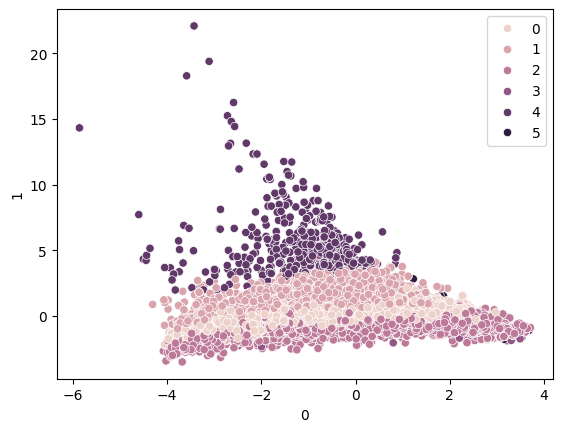

In [102]:
sns.scatterplot(x=df_v[0], y=df_v[1], hue=labels)


<Axes: xlabel='0', ylabel='1'>

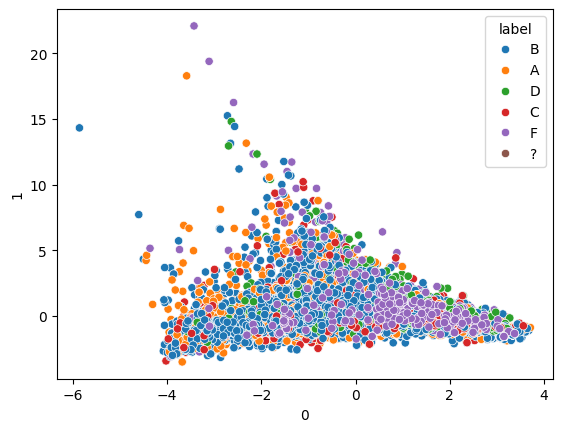

In [ ]:
sns.scatterplot(x=df_v[0], y=df_v[1], hue=df_v["label"],)


In [76]:
df_v[df_v["label"]=="F"][0]/df_v[df_v["label"]=="F"][1]

1000    -11.965703
1001     95.787065
1002     -2.160401
1003     -6.773740
1004     -2.871915
           ...    
18490   -10.656905
18491    -6.212939
18492    -8.941454
18493     0.049966
18494     3.102962
Length: 1161, dtype: float64

In [67]:
unique_labels

array(['?', 'A', 'B', 'C', 'D', 'F'], dtype=object)

In [68]:
df_v

,0,1,label
0,-22.146246,-4.890258,B
1,-7.367517,-4.460928,B
2,-27.950134,-5.062157,B
3,-13.971132,-4.657210,B
4,-23.756301,-4.940004,B
...,...,...,...
18490,29.974130,-2.812649,F
18491,19.385063,-3.120112,F
18492,26.159361,-2.925627,F
18493,-0.184383,-3.690177,F


# Suspecious pattern - daily number of reviews

In [5]:
import datetime
import re

def extract_date_from_review_string(review_string):
  """Extracts the date from a review string in the format """
  pattern = r"([A-Za-z]+ \d{1,2}, \d{4})"
  match = re.search(pattern, review_string)

  if match:
    date_string = match.group(1)
    date_object = datetime.datetime.strptime(date_string, "%B %d, %Y").date()
    return date_object
  else:
    return None

In [6]:
import pickle
with open("product_reviews.pkl", 'rb') as f:  # 'wb' for writing in binary mode
    product_reviews = pickle.load(f)
    print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


In [7]:
import pickle
with open("fakesport_grade.pkl", 'rb') as f:  # 'wb' for writing in binary mode
    fakespot_grade = pickle.load(f)
    print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


In [9]:
import numpy as np
product_review_dates = {}
for product_url, review_dict in product_reviews.items():
    product_review_dates.setdefault(product_url, {})
    for review_id, review_details in review_dict.items():
        review_date = extract_date_from_review_string(review_details["review_date"])
        if review_date:
            product_review_dates[product_url].setdefault(review_date, 0)
            product_review_dates[product_url][review_date] += 1

product_daily_count_stats = {}
for product_url, daily_count in product_review_dates.items():
    product_daily_count_stats.setdefault(product_url, {})
    product_daily_count_stats[product_url]["var"]=np.var(list(daily_count.values()))
    product_daily_count_stats[product_url]["mean"]=np.mean(list(daily_count.values()))
    product_daily_count_stats[product_url]["std"]=np.std(list(daily_count.values()))
    product_daily_count_stats[product_url]["cv"]=np.std(list(daily_count.values()))/np.mean(list(daily_count.values()))


In [11]:
import pandas as pd
df_daily_count_stats = pd.DataFrame(product_daily_count_stats).T
df_daily_count_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_daily_count_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/1838651941.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="cv", data=df_daily_count_stats, palette="viridis")


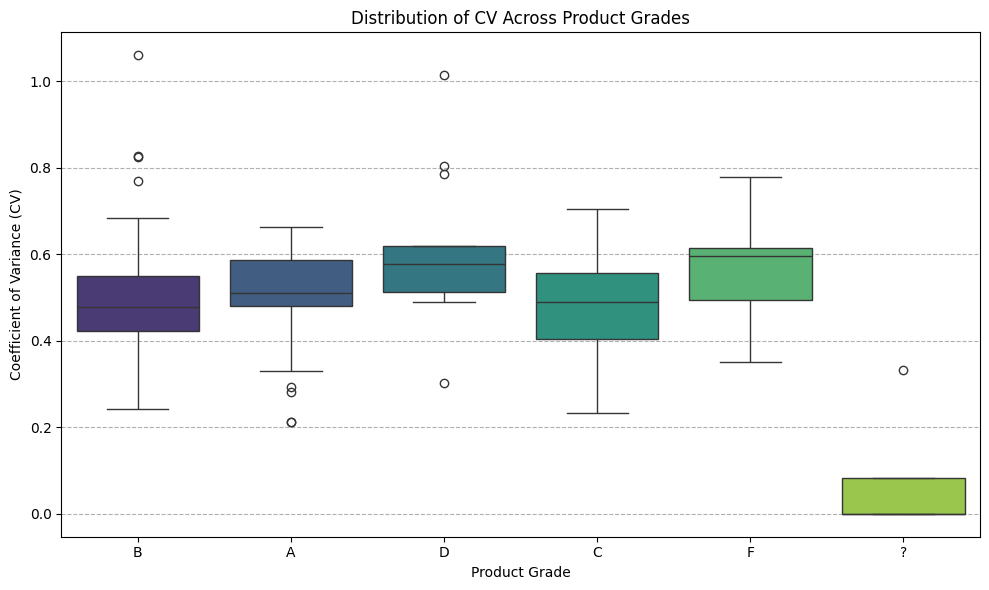

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="cv", data=df_daily_count_stats, palette="viridis")
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [243]:
# review length

# Suspecious pattern - number of token per review

In [245]:
import pickle
with open("df_all_product_features.pkl", 'rb') as f:  # 'wb' for writing in binary mode
    df_all_product_features = pickle.load(f)
    print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


In [13]:
review_token_length = df_all_product_features[["feature_3", "product_url"]].groupby("product_url")["feature_3"].apply(list).to_dict()
review_token_length_stats = {}
for product_url, pos_sen  in review_token_length.items():
    review_token_length_stats.setdefault(product_url, {})
    review_token_length_stats[product_url]["mean"] = np.mean(pos_sen)
    review_token_length_stats[product_url]["std"] = np.std(pos_sen)
    review_token_length_stats[product_url]["var"] = np.var(pos_sen)
    review_token_length_stats[product_url]["cv"] = np.std(pos_sen)/np.mean(pos_sen)

In [14]:
df_review_token_length_stats = pd.DataFrame(review_token_length_stats).T
df_review_token_length_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_review_token_length_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/2385839708.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="cv", data=df_review_token_length_stats, palette="viridis")


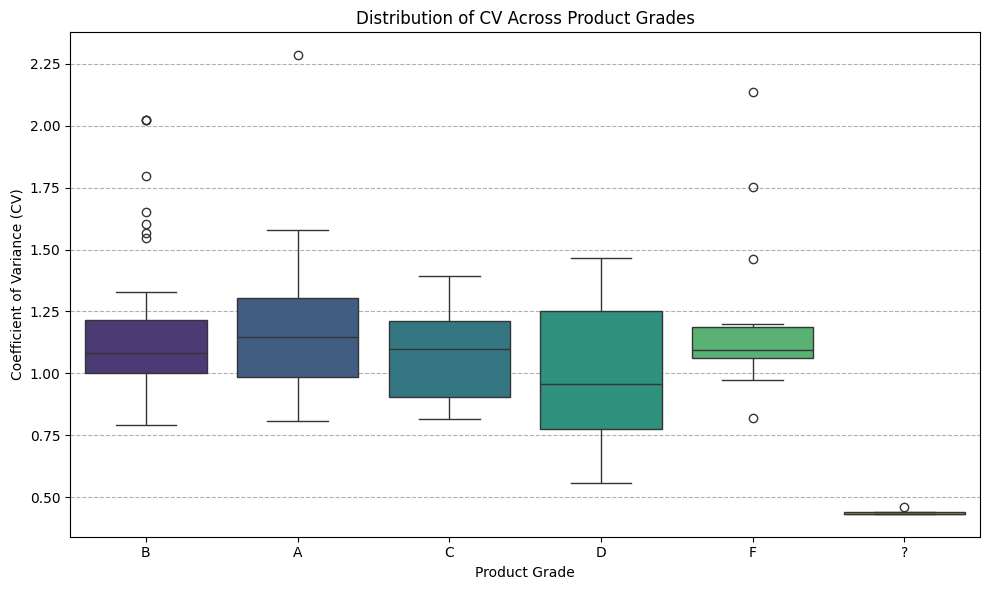

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="cv", data=df_review_token_length_stats, palette="viridis")
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Suspecious pattern - Similarity of reviews

In [16]:
product_token_dict = df_all_product_features[["token_string", "product_url"]].groupby("product_url")["token_string"].apply(list).to_dict()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

product_similarity_score = {}
for product_url, review_list in product_token_dict.items():
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(review_list)
    similarity_matrix = cosine_similarity(tfidf_matrix)
        # Extract scores
    scores = []
    for i in range(len(similarity_matrix)):
      for j in range(i + 1, len(similarity_matrix)):
          scores.append(similarity_matrix[i, j])
    scores = np.array(scores)
    if(len(scores) == 0):
        product_scores = {"mean":0, "median":0, "std":0, "scores":[]}
    else:
        product_scores =  {"mean": np.mean(scores), "median": np.median(scores), "std": np.std(scores), "scores": scores}
    product_similarity_score[product_url] = product_scores

In [21]:
df_product_review_similarity_stats = pd.DataFrame(product_similarity_score).T
df_product_review_similarity_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_product_review_similarity_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/1100456858.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="median", data=df_product_review_similarity_stats, palette="viridis")


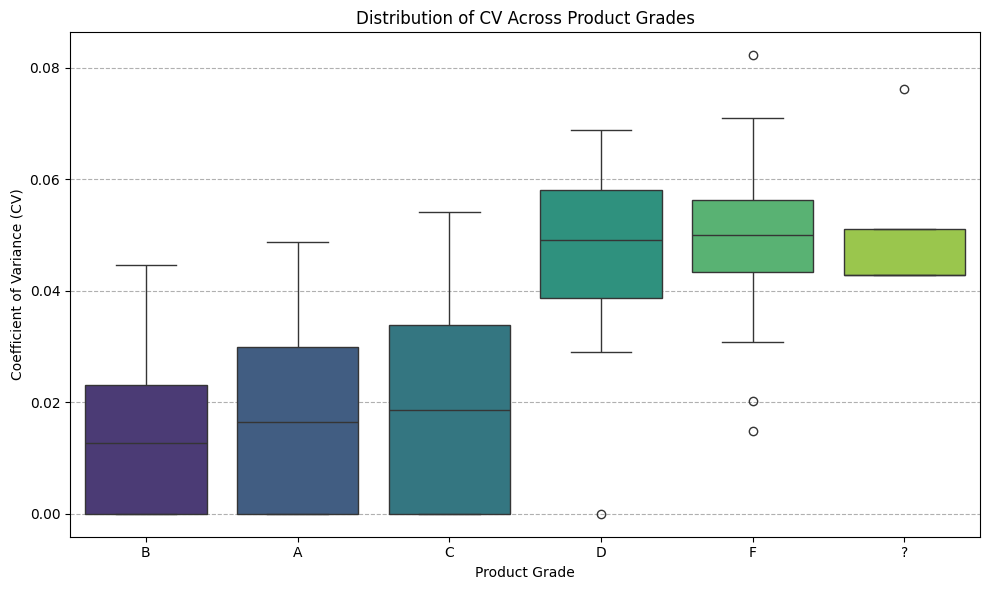

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="median", data=df_product_review_similarity_stats, palette="viridis")
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [288]:
#review_rating_ratio

# Suspecious pattern - Ratio on number of reviews over number of ratings

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/34296474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="product_fakespot_grade", y="review_rating_ratio", data=df_all_product_features[df_all_product_features["review_rating_ratio"]<1], palette="viridis", order=["A","B","C","D","F","?"])


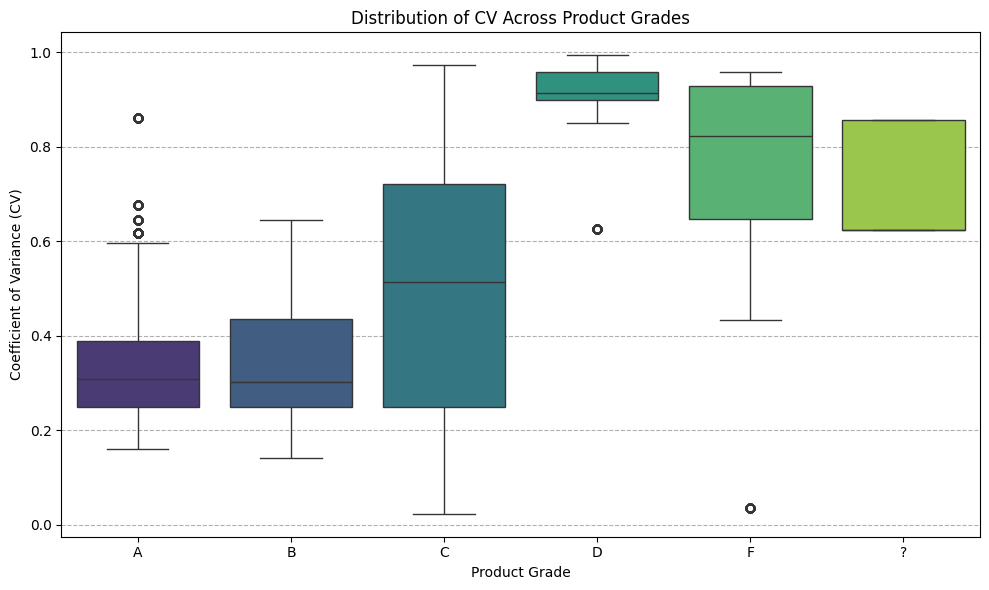

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="product_fakespot_grade", y="review_rating_ratio", data=df_all_product_features[df_all_product_features["review_rating_ratio"]<1], palette="viridis", order=["A","B","C","D","F","?"])
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Suspecious pattern - percentage of number of reviews with image

In [25]:
review_image_count_dict = df_all_product_features.groupby("product_url")["feature_0"].apply("value_counts").to_dict()
review_with_image_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_image_count_dict.items() if url_bool_tuple[1] is True}
review_without_image_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_image_count_dict.items() if url_bool_tuple[1] is False}
df_image_count =pd.DataFrame.from_dict(review_with_image_count_dict, orient="index", columns=["count_review_with_image"])
df_no_image_count =pd.DataFrame.from_dict(review_without_image_count_dict, orient="index", columns=["count_review_without_image"])
df_review_images_count = pd.merge(df_image_count, df_no_image_count, left_index=True, right_index=True)

missing_index = [prod[0] for prod in review_image_count_dict.keys() if prod[0] not in df_review_images_count.index]
df_review_images_count["total_count"] = df_review_images_count["count_review_with_image"] + df_review_images_count["count_review_without_image"]
df_review_images_count["rate_of_review_with_image"] = df_review_images_count["count_review_with_image"]/df_review_images_count["total_count"]
df_review_images_count["fakespot_grade"] = df_review_images_count.index.map(fakespot_grade)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3525518569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="rate_of_review_with_image", data=df_review_images_count, palette="viridis", order=["A","B","C","D","F","?"])


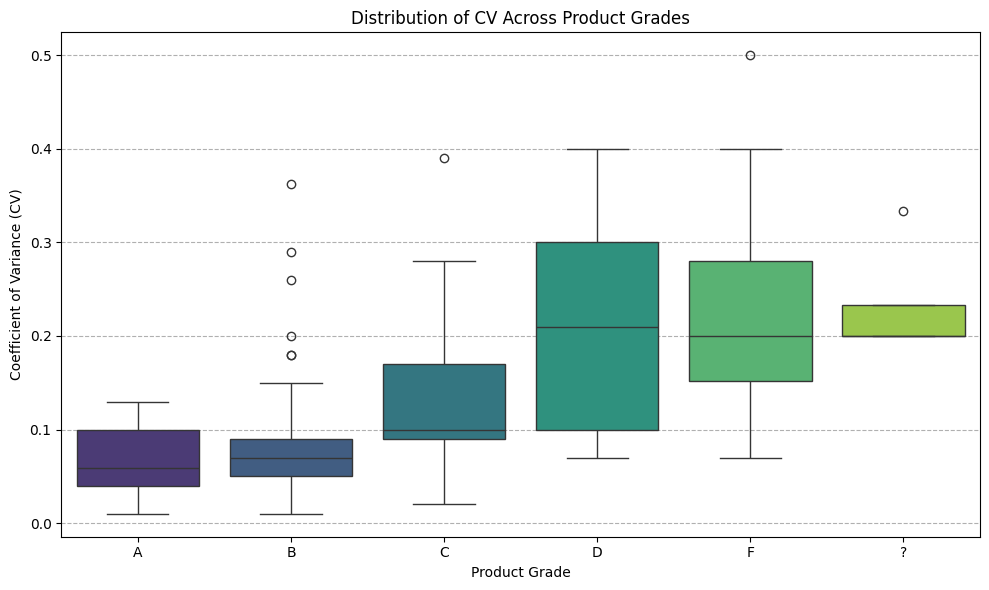

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="rate_of_review_with_image", data=df_review_images_count, palette="viridis", order=["A","B","C","D","F","?"])
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Suspecious pattern - percentage of number of reviews with videos

In [27]:
review_video_count_dict = df_all_product_features.groupby("product_url")["feature_1"].apply("value_counts").to_dict()
review_with_video_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_video_count_dict.items() if url_bool_tuple[1] is True}
review_without_video_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_video_count_dict.items() if url_bool_tuple[1] is False}
df_video_count =pd.DataFrame.from_dict(review_with_video_count_dict, orient="index", columns=["count_review_with_video"])
df_no_video_count =pd.DataFrame.from_dict(review_without_video_count_dict, orient="index", columns=["count_review_without_video"])
df_review_video_count = pd.merge(df_video_count, df_no_video_count, left_index=True, right_index=True)

missing_index = [prod[0] for prod in review_video_count_dict.keys() if prod[0] not in df_review_video_count.index]
df_review_video_count["total_count"] = df_review_video_count["count_review_with_video"] + df_review_video_count["count_review_without_video"]
df_review_video_count["rate_of_review_with_video"] = df_review_video_count["count_review_with_video"]/df_review_video_count["total_count"]
df_review_video_count["fakespot_grade"] = df_review_video_count.index.map(fakespot_grade)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3271797588.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="rate_of_review_with_video", data=df_review_video_count, palette="viridis", order=["A","B","C","D","F","?"])


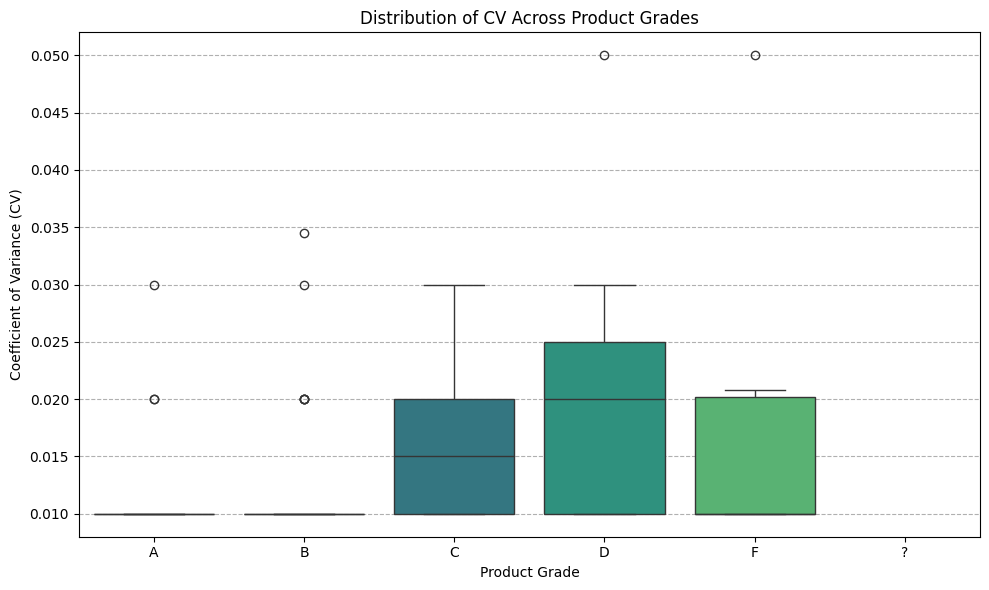

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="rate_of_review_with_video", data=df_review_video_count, palette="viridis", order=["A","B","C","D","F","?"])
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### sentiment

In [29]:
review_pos_sentiment = df_all_product_features[["feature_6", "product_url"]].groupby("product_url")["feature_6"].apply(list).to_dict()
review_pos_sentiment_stats = {}
for product_url, pos_sen  in review_pos_sentiment.items():
    review_pos_sentiment_stats.setdefault(product_url, {})
    review_pos_sentiment_stats[product_url]["mean"] = np.mean(pos_sen)
    review_pos_sentiment_stats[product_url]["std"] = np.std(pos_sen)
    review_pos_sentiment_stats[product_url]["var"] = np.var(pos_sen)
    review_pos_sentiment_stats[product_url]["cd"] = np.std(pos_sen)/np.mean(pos_sen)

In [30]:
df_review_pos_sentiment_stats = pd.DataFrame(review_pos_sentiment_stats).T
df_review_pos_sentiment_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_review_pos_sentiment_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3451731199.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="mean", data=df_review_pos_sentiment_stats, palette="viridis", order=["A","B","C","D","F","?"])


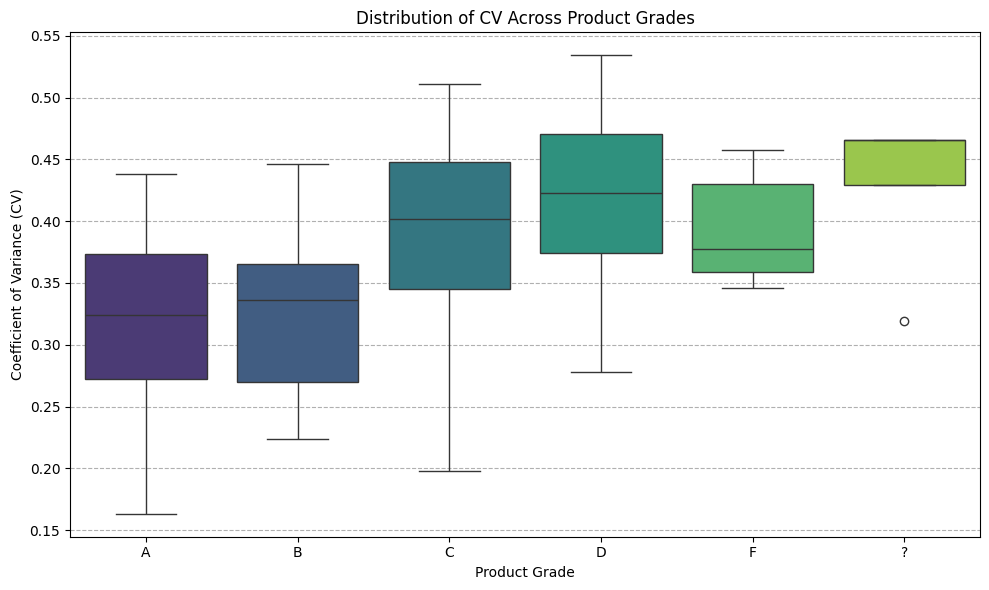

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="mean", data=df_review_pos_sentiment_stats, palette="viridis", order=["A","B","C","D","F","?"])
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Experimental modelling - classification

Building a binary classification model to classify if a the review is legit (not fake). 

Assumption:
- Assume all the reviews in grade F are fake, and all the reviews in grade A are legit
- Train a classifier to classify on every grade
- Based on percentage of classified A & F, and define a list of threshold/range, we can define or give a grade to each product based on the reviews

Data preprocessing:
- text preprocessing
- tokenization
- generate basic nlp features for reviews
- calculate product level features discussed above, reviews on same product shares the same values

Train test split:
- reviews by same product are treated as unsplitable data group, so the train test split is split by product url
- all reviews from a product should be either in the training set, or testing set

models:
- Basic benchmark model - random forest
- XGBoost Classifier

In [2]:
import pickle
with open("df_all_product_features.pkl", 'rb') as f:  # 'wb' for writing in binary mode
    df_all_product_features = pickle.load(f)
    print(f"Dictionary successfully loaded.")

Dictionary successfully loaded.


In [ ]:
import pandas as pd
def generat_fake_df(n_data_points):
    """n_data_points: interger of the length of df"""
    df = pd.DataFrame({f'col_{n}': "generate random data" for n in range(n_data_points)}, index=[n for n in range(n_data_points)])
    return df

In [157]:
generat_fake_df(30)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
1,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
2,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
3,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
4,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
5,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
6,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
7,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
8,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data,generate random data
9,generate random data,generate random data,generate random data,genera

In [32]:
# percentage of num. reviews with image
review_with_image_counts = df_all_product_features.groupby("product_url")["feature_0"].sum().to_dict()
review_counts = df_all_product_features.groupby("product_url")["feature_0"].count().to_dict()
review_with_image_percentage = {}
for product_url, count in review_counts.items():
    review_with_image_percentage[product_url] = review_with_image_counts.get(product_url, 0)/ review_counts[product_url] 

In [33]:
# percentage of num. reviews with image
review_with_video_counts = df_all_product_features.groupby("product_url")["feature_1"].sum().to_dict()
review_with_video_percentage = {}
for product_url, count in review_counts.items():
    review_with_video_percentage[product_url] = review_with_video_counts.get(product_url, 0)/ review_counts[product_url] 

In [34]:
# coefficient of variance for daily number of reviews (how fluctuated on the daily review count)
cv_daily_review_count = {product_url: d["cv"] for product_url, d in product_daily_count_stats.items()}

In [35]:
# coefficient of variance for number of token of reviews (how fluctuated on the length of the review)
cv_review_token_length = {product_url: d["cv"] for product_url, d in review_token_length_stats.items()}

In [36]:
# similarity of the reviews
product_similarity_score_mean = {product_url: d["mean"] for product_url, d in product_similarity_score.items()}
product_similarity_score_median = {product_url: d["median"] for product_url, d in product_similarity_score.items()}

In [37]:
df_all_product_features["review_with_image_percentage"] = df_all_product_features["product_url"].map(review_with_image_percentage)
df_all_product_features["review_with_video_percentage"] = df_all_product_features["product_url"].map(review_with_video_percentage)
df_all_product_features["cv_daily_review_count"] = df_all_product_features["product_url"].map(cv_daily_review_count)
df_all_product_features["cv_review_token_length"] = df_all_product_features["product_url"].map(cv_review_token_length)
df_all_product_features["product_similarity_score_mean"] = df_all_product_features["product_url"].map(product_similarity_score_mean)
df_all_product_features["product_similarity_score_median"] = df_all_product_features["product_url"].map(product_similarity_score_median)


In [38]:
feature_cols = [col for col in df_all_product_features.columns if col not in ["product_fakespot_grade", "token_string", "product_url"]]

In [423]:
# train test split

In [39]:
# get only A & F products from the df
df_model_data = df_all_product_features[df_all_product_features["product_fakespot_grade"].isin(["A", "F"])]

In [ ]:
df_model_data["product_fakespot_grade"] = df_model_data["product_fakespot_grade"].replace("A", 1)
df_model_data["product_fakespot_grade"] = df_model_data["product_fakespot_grade"].replace("F", 0)
product_grade_df = df_model_data[["product_url", "product_fakespot_grade"]].drop_duplicates()

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(product_grade_df["product_url"], product_grade_df["product_fakespot_grade"], test_size=0.3, random_state=42)

In [44]:
y_train, y_test = df_model_data[df_model_data["product_url"].isin(X_train.values)]["product_fakespot_grade"].values, df_model_data[df_model_data["product_url"].isin(X_test.values)]["product_fakespot_grade"].values

In [45]:
df_model_data = df_model_data.replace(True, 1)
df_model_data = df_model_data.replace(False, 0)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3457774219.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model_data = df_model_data.replace(True, 1)
/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3457774219.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model_data = df_model_data.replace(False, 0)


In [46]:
X_train_with_features, X_test_with_features = df_model_data[df_model_data["product_url"].isin(X_train.values)][feature_cols].values, df_model_data[df_model_data["product_url"].isin(X_test.values)][feature_cols].values

In [48]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler()
X_train_features_scaled = scaler.fit_transform(X_train_with_features)
X_test_features_scaled = scaler.transform(X_test_with_features)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_model_data[df_model_data["product_url"].isin(X_train.values)]["token_string"].values)
X_test_vec = vectorizer.transform(df_model_data[df_model_data["product_url"].isin(X_test.values)]["token_string"].values)

# # extract only features from df and join with TF-IDF features
# X_train_df = df_product_review.loc[X_train.index, [col for col in df_product_review.columns if col.startswith("feature") or col == "count_ratio"]]
# X_train_df = X_train_df.join(pd.DataFrame(X_train_vec.toarray()))
# X_test_df = df_product_review.loc[X_test.index, [col for col in df_product_review.columns if col.startswith("feature") or col == "count_ratio"]]
# X_test_df = X_test_df.join(pd.DataFrame(X_test_vec.toarray()))

# X_train, X_test = X_train_df.values, X_test_df.values


In [49]:
X_train_all_features = np.concatenate((X_train_features_scaled, X_train_vec.toarray()), axis=1)
X_test_all_features = np.concatenate((X_test_features_scaled, X_test_vec.toarray()), axis=1)

In [120]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)  # Reduce to, say, 100 dimensions
X_train_reduced_features = svd.fit_transform(X_train_all_features)
X_test_reduced_features = svd.transform(X_test_all_features)

In [121]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
oversampler = SMOTE(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X_train_reduced_features, y_train)

In [122]:
# benchmark model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


model = RandomForestClassifier(random_state=42, class_weight='balanced') 

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
# Parameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

# Get best model and its best parameters
model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [123]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_reduced_features)
print("\nEvaluation Metrics:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       417
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      1717
   macro avg       0.97      0.96      0.97      1717
weighted avg       0.98      0.98      0.98      1717

Accuracy: 0.9761211415259173


In [55]:
# test on other products

In [136]:
grades = ["A", "B", "C", "D","F"]

In [151]:
for grade in grades:
    df_b = df_all_product_features[(df_all_product_features["product_fakespot_grade"].isin([grade])) & (~df_all_product_features["product_url"].isin(X_train.values))]
    df_b = df_b.replace({True: 1, False: 0}).infer_objects(copy=False)

    X_test_b = df_b[feature_cols].values
    X_test_b_features_scaled = scaler.transform(X_test_b)
    X_test_b_vec = vectorizer.transform(df_b["token_string"].values)
    X_test_b_all_features = np.concatenate((X_test_b_features_scaled, X_test_b_vec.toarray()), axis=1)
    X_test_b_reduced_features = svd.transform(X_test_b_all_features)

    y_b_pred = model.predict(X_test_b_reduced_features)
    F_rate = list(y_b_pred).count(1)/len(y_b_pred)
    print(f"grade {grade}, rate {F_rate}")

grade A, rate 0.9907692307692307
grade B, rate 0.954853034468175
grade C, rate 0.788829005389515
grade D, rate 0.23615384615384616
grade F, rate 0.06954436450839328


0.997341603898981

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#function to split text into word
product_features = {}
for product_url, p_dict in product_reviews.items():
    product_features.setdefault(product_url, {})
    for review_id, review_d in p_dict.items():
        # create tokens
        product_features[product_url].setdefault(review_id, {})
        tokens = preprocess_text_and_get_tokens(review_d["review_text"])
        product_features[product_url][review_id]["tokens"] = tokens

        # extract basic features
        feature_dict = extract_features(product_features[product_url][review_id]["tokens"])
        product_features[product_url][review_id]["feature_dict"] = feature_dict

        # reconstruct string by token 
        token_string = " ".join([token for token in product_features[product_url][review_id]["tokens"]])
        product_features[product_url][review_id]["token_string"] = token_string

        # create feature list
        feature_list = []
        feature_list.append(review_d["has_image"])
        feature_list.append(review_d["has_video"])
        feature_list.append(review_d["review_rating"])
        feature_list.extend(list(product_features[product_url][review_id]["feature_dict"].values()))
        product_features[product_url][review_id]["features"] = feature_list

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,token_string,product_url,review_rating_ratio,product_fakespot_grade
R30SZV56T07JOV,False,False,4,9,6.111111,7,0.577,0.0,0.423,0.8012,quality sound really good good quality materia...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R2YD8IZAN1L5QV,False,False,1,20,4.5,17,0.0,0.217,0.783,-0.6124,difficult pair pair alexa never got work even ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1SG3KLESASNYO,False,False,4,4,5.5,4,0.516,0.0,0.484,0.4927,price product really good,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1BRUHA6158TD1,False,False,1,14,5.357143,14,0.326,0.163,0.512,0.5423,product performs 20 ear bud design great idea ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R3IK00EI1WUVQO,False,False,4,7,5.714286,7,0.406,0.0,0.594,0.6249,great battery life connection volume 100 phone,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R3FRDB5B4OBRUA,False,False,2,48,5.25,42,0.128,0.053,0.819,0.4703,despite use 54 bluetooth chip 142 mm driver so...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R1K92OG4FIP8XR,False,False,5,40,5.975,35,0.507,0.0,0.493,0.9832,absolutely fantastic use driving job great bat...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R3898SHCPYITBL,False,False,5,44,4.568182,41,0.445,0.063,0.493,0.9766,work awesome airpod pro 2 new one spent 270 le...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R23NZFM6ADIX2Q,False,False,5,26,4.423077,21,0.503,0.0,0.497,0.9649,love color fit comfortable ear case let know m...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F


In [373]:
from nltk.util import ngrams
import nltk
from collections import Counter
import string


def analyze_ngrams(text, n):
    """
    Performs n-gram analysis on a given text.

    Args:
        text: The text to analyze.
        n: The size of the n-grams (e.g., 2 for bigrams).

    Returns:
        A Counter object containing the n-grams and their frequencies.
    """

    # Tokenize and clean the text
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # Generate n-grams
    n_grams = ngrams(tokens, n)

    # Count frequencies
    n_gram_counts = Counter(n_grams)

    return n_gram_counts

In [378]:
grades = ["A", "B", "C", "D", "F"]
ngram_data = {}
n = 2 # Example: Bigrams
for grade in ["A", "B", "C", "D", "F"]:
    reviews_grade_dict = df_all_product_features[df_all_product_features["product_fakespot_grade"]==grade]["token_string"].to_dict()
    all_ngram_counts = Counter() # Aggregate counts across all reviews

    for review in reviews_grade_dict.values():
        ngram_counts = analyze_ngrams(review, n)
        all_ngram_counts.update(ngram_counts)  # Add counts to the overall counter


    # Print overall top N n-grams:
    print(f"Top {n}-grams across all reviews:")
    for ngram, count in all_ngram_counts.most_common(10): # Print top 10
        print(f"grade {grade} {ngram}: {count}")
    ngram_data[grade] = all_ngram_counts


Top 2-grams across all reviews:
grade A ('sound', 'quality'): 369
grade A ('battery', 'life'): 296
grade A ('ear', 'bud'): 125
grade A ('great', 'sound'): 120
grade A ('sound', 'great'): 108
grade A ('work', 'great'): 100
grade A ('good', 'sound'): 98
grade A ('noise', 'canceling'): 93
grade A ('stopped', 'working'): 93
grade A ('noise', 'cancellation'): 91
Top 2-grams across all reviews:
grade B ('sound', 'quality'): 966
grade B ('battery', 'life'): 579
grade B ('ear', 'bud'): 302
grade B ('great', 'sound'): 282
grade B ('noise', 'cancelling'): 280
grade B ('sound', 'great'): 255
grade B ('noise', 'canceling'): 221
grade B ('good', 'sound'): 217
grade B ('noise', 'cancellation'): 197
grade B ('stopped', 'working'): 190
Top 2-grams across all reviews:
grade C ('sound', 'quality'): 314
grade C ('battery', 'life'): 197
grade C ('ear', 'bud'): 99
grade C ('great', 'sound'): 90
grade C ('noise', 'cancelling'): 83
grade C ('easy', 'use'): 68
grade C ('sound', 'great'): 68
grade C ('good', '